In [11]:
import os

if os.getcwd().endswith("notebooks"):
    os.chdir("..")
    print("using project root as working dir")

In [12]:
from dataclasses import dataclass
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import networkx as nx
import seaborn as sns
import math
from tqdm.notebook import tqdm
import random
from typing import List, Tuple


@dataclass
class Args:
    random_seed = None
    # torch
    batch_size = 10
    epochs = 100
    layers = 10
    layer_size = 16
    train_size = 0.8
    wandb = False
    # graph
    graph_size = 100
    graph_shape = 'disc'
    rg_radius = 0.15

args = Args()

In [13]:
import torch
from torch import nn
from torch.utils.data import Dataset, TensorDataset, DataLoader, WeightedRandomSampler
from sklearn.metrics import classification_report


# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else ("mps" if torch.backends.mps.is_available() else "cpu")
print(f"using {device} device")

using cuda device


In [14]:
NodePosition = Tuple[float, float]
NodePositions = List[NodePosition]
NodeIndexPairs = List[Tuple[int, int]]

def gen_nodes(size: int, shape: str = "disc") -> NodePositions:
    if shape == 'disc':
        return __gen_nodes_disc(size)
    else:
        raise f'unsupported node shape: {shape}'


def __gen_nodes_disc(amount: int) -> NodePositions:
    points = []
    with tqdm(total=amount, desc="generating random-uniform nodes on disc") as pbar:
        while len(points) < amount:
            p = (random.uniform(0, 1), random.uniform(0, 1))
            d = (p[0] - 0.5, p[1] - 0.5)
            if math.sqrt(d[0] * d[0] + d[1] * d[1]) > 0.5:
                continue
            points.append(p)
            pbar.update(1)
    return points


def get_node_pairs(n_nodes: int) -> NodeIndexPairs:
    return [
        (i0, i1)
        for i0 in tqdm(range(n_nodes), desc="generating node pairs")
        for i1 in range(i0 + 1, n_nodes)
    ]


# https://stackoverflow.com/a/36460020/10619052
def list_to_dict(items: list) -> dict:
    return {v: k for v, k in enumerate(tqdm(items, desc="creating dict from list"))}

In [15]:
# Define graph builder
class RandomGeometricGraphBuilder:
    def __init__(self):
        # generate graph
        self.nodes = gen_nodes(args.graph_size, args.graph_shape)
        self.n_nodes = len(self.nodes)
        self.graph = nx.random_geometric_graph(
            self.n_nodes,
            args.rg_radius,
            pos=list_to_dict(self.nodes)
        )
        self.node_index_pairs = get_node_pairs(self.n_nodes)
        self.edges: NodeIndexPairs = [
            (i0, i1)
            for (i0, i1) in tqdm(self.node_index_pairs, desc="generating dataset labels from node pairs")
            if self.graph.has_edge(i0, i1)
        ]

In [16]:
# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        #self.linear_relu_stack = nn.Sequential(
        #    nn.Linear(4, args.layer_size),
        #    nn.ReLU(),
        #    nn.Linear(args.layer_size, args.layer_size),
        #    nn.ReLU(),
        #    nn.Linear(args.layer_size, 2)
        #)
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(4, args.layer_size),
            nn.ReLU(),
            nn.Linear(args.layer_size, args.layer_size),
            nn.ReLU(),
            nn.Linear(args.layer_size, args.layer_size),
            nn.ReLU(),
            nn.Linear(args.layer_size, args.layer_size),
            nn.ReLU(),
            nn.Linear(args.layer_size, args.layer_size),
            nn.ReLU(),
            nn.Linear(args.layer_size, args.layer_size),
            nn.ReLU(),
            nn.Linear(args.layer_size, args.layer_size),
            nn.ReLU(),
            nn.Linear(args.layer_size, args.layer_size),
            nn.ReLU(),
            nn.Linear(args.layer_size, args.layer_size),
            nn.ReLU(),
            nn.Linear(args.layer_size, 2)
        )

    def forward(self, x):
        return self.linear_relu_stack(x)

In [17]:
# Define evaluator
class EmbeddingEvaluator:
    def __init__(self, nodes: NodePositions, edges: NodeIndexPairs, embedding: NodePositions):
        self.nodes = nodes # used for 2D representation of graph (not used in training)
        self.n_nodes = len(nodes)
        self.node_index_pairs = get_node_pairs(self.n_nodes)
        self.edges = edges
        self.embedding = embedding
        # generate net
        self.net = None
        self.reset_net()
        # generate dataset
        self.ds_values = torch.tensor([
            [*self.embedding[i0], *self.embedding[i1]] # type: [float, float, float, float]
            for (i0, i1) in tqdm(self.node_index_pairs, desc="generating dataset values from node pairs")
        ])
        self.ds_labels = torch.LongTensor([
            1 if (edge in self.edges) else 0
            for edge in tqdm(self.node_index_pairs, desc="generating dataset labels from node pairs")
        ])
        self.dataset = TensorDataset(self.ds_values, self.ds_labels)
        #? do we ant to over-fit?
        self.train_dataset, self.test_dataset = torch.utils.data.random_split(self.dataset, [args.train_size, 1 - args.train_size])
        # use custom sampler that keeps labels in balance
        labels_unique, labels_count = np.unique(self.ds_labels, return_counts=True) # independent of train-test split (has both classes)
        labels_weights = [
            (1 / labels_count[l])
            for _, l in self.train_dataset
        ]
        self.train_sampler = WeightedRandomSampler(labels_weights, len(self.train_dataset), replacement=True)

        self.train_dataloader = DataLoader(self.train_dataset, batch_size=args.batch_size, sampler=self.train_sampler)
        self.test_dataloader = DataLoader(self.test_dataset, batch_size=args.batch_size)


    def reset_net(self):
        self.net = NeuralNetwork().to(device)


    def train(self, loss_fn, optimizer):
        for epoch in range(args.epochs):
            with tqdm(total=len(self.train_dataloader), desc="starting model...") as pbar:
                pbar.set_description(f"Epoch {epoch + 1}")
                self.__train(pbar, loss_fn, optimizer)
                self.__test(pbar, loss_fn)


    def __train(self, pbar, loss_fn, optimizer):
        self.net.train()

        n_train_batches = len(self.train_dataloader)
        intv = np.ceil(n_train_batches / 100.0) # interval in which the pbar is updated (every 1%)
        for idx_batch, (X, y) in enumerate(self.train_dataloader):
            X, y = X.to(device), y.to(device)
            # Compute prediction error
            pred = self.net(X)
            loss = loss_fn(pred, y)
            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            # update progress
            if idx_batch % intv == 0 or idx_batch == n_train_batches - 1:
                pbar.update(idx_batch - pbar.n)
                pbar.set_postfix_str(f"loss: {loss.item():>6f}")


    def __test(self, pbar, loss_fn):
        self.net.eval()

        n_test_batches = len(self.test_dataloader)
        n_test_values = 0
        test_loss, correct = 0, 0
        pbar.set_postfix_str(f"evaluating epoch...")
        with torch.no_grad():
            for x, y in self.test_dataloader:
                x, y = x.to(device), y.to(device)
                pred = self.net(x)
                test_loss += loss_fn(pred, y).item()
                correct += (pred.argmax(1) == y).type(torch.float).sum().item()
                n_test_values += len(pred)
        test_loss /= n_test_batches
        correct /= n_test_values
        pbar.set_postfix_str(f"epoch result: accuracy: {(100*correct):>0.1f}%, avg_loss: {test_loss:>8f}")


    def predict(self, embedding: NodePositions):
        self.net.eval()

        _node_index_pairs = get_node_pairs(len(embedding))
        _ds_values = torch.tensor([
            [*embedding[i0], *embedding[i1]] # type: [float, float, float, float]
            for (i0, i1) in tqdm(_node_index_pairs, desc="generating dataset values from node pairs")
        ])
        with torch.no_grad():
            return self.net(_ds_values.to(device))


    def evaluate(self, print_report: bool = True, print_graph: bool = True):
        self.net.eval()

        with torch.no_grad():
            _predictions = self.net(self.ds_values.to(device))
            _, _pred_labels = torch.max(_predictions, 1)
            _probabilities = torch.nn.Softmax(dim=1)(_predictions)

            if print_report:
                print(classification_report(
                    self.ds_labels,
                    _pred_labels.cpu(),
                    labels=[0, 1]
                ))

            if print_graph:
                self.__print_graph(_pred_labels.cpu().numpy(), _probabilities.cpu().numpy())

            return _predictions, _pred_labels, _probabilities


    def __print_graph(self, pred_labels: List[int], probabilities: List[Tuple[float, float]]):
        fig, ax = plt.subplots(1, 2)
        nodes_dict = list_to_dict(self.nodes)

        # generate embedding graph
        embed_graph = nx.Graph()
        embed_graph.add_nodes_from(range(self.n_nodes))
        embed_graph.add_edges_from(self.edges)

        # print embed graph
        ax[0].set_axis_off()
        ax[0].set_aspect('equal')
        ax[0].set_title("original graph")
        nx.draw_networkx(embed_graph, pos=nodes_dict, ax=ax[0], node_size=5, with_labels=False, labels={})

        # generate predict graph
        colors_filtered = np.array([
            probabilities[i][1] # take probability for class '1'
            for i, _ in enumerate(self.node_index_pairs)
            if pred_labels[i] == 1
        ])
        colormap = sns.color_palette("flare", as_cmap=True)
        pred_graph = nx.Graph()
        pred_graph.add_nodes_from(range(self.n_nodes))
        pred_graph.add_edges_from([
            pair
            for i, pair in enumerate(self.node_index_pairs)
            if pred_labels[i] == 1
        ])

        # print predicted graph
        ax[1].set_axis_off()
        ax[1].set_aspect('equal')
        ax[1].set_title("reconstructed graph")
        nx.draw_networkx(pred_graph, pos=nodes_dict, ax=ax[1], node_size=5, with_labels=False, labels={}, edge_color=colors_filtered, edge_cmap=colormap)

        # add color bar for predictions
        cax = fig.add_axes([ax[1].get_position().x1 + 0.01, ax[1].get_position().y0, 0.02, ax[1].get_position().height])
        fig.colorbar(mpl.cm.ScalarMappable(cmap=colormap), cax=cax, label="confidence")

        plt.savefig('./filename.png', dpi=300)
        plt.show()

In [18]:
# build and run evaluator
graph_builder = RandomGeometricGraphBuilder()
evaluator = EmbeddingEvaluator(
    graph_builder.nodes,
    graph_builder.edges,
    graph_builder.nodes # for random geometric graph, the structure defines the embedding
)

evaluator.train(
    loss_fn=nn.CrossEntropyLoss(),
    optimizer=torch.optim.SGD(evaluator.net.parameters(), lr=1e-3)
)

generating random-uniform nodes on disc:   0%|          | 0/100 [00:00<?, ?it/s]

creating dict from list:   0%|          | 0/100 [00:00<?, ?it/s]

generating node pairs:   0%|          | 0/100 [00:00<?, ?it/s]

generating dataset labels from node pairs:   0%|          | 0/4950 [00:00<?, ?it/s]

generating node pairs:   0%|          | 0/100 [00:00<?, ?it/s]

generating dataset values from node pairs:   0%|          | 0/4950 [00:00<?, ?it/s]

generating dataset labels from node pairs:   0%|          | 0/4950 [00:00<?, ?it/s]

starting model...:   0%|          | 0/397 [00:00<?, ?it/s]

starting model...:   0%|          | 0/397 [00:00<?, ?it/s]

starting model...:   0%|          | 0/397 [00:00<?, ?it/s]

starting model...:   0%|          | 0/397 [00:00<?, ?it/s]

starting model...:   0%|          | 0/397 [00:00<?, ?it/s]

starting model...:   0%|          | 0/397 [00:00<?, ?it/s]

starting model...:   0%|          | 0/397 [00:00<?, ?it/s]

starting model...:   0%|          | 0/397 [00:00<?, ?it/s]

starting model...:   0%|          | 0/397 [00:00<?, ?it/s]

starting model...:   0%|          | 0/397 [00:00<?, ?it/s]

starting model...:   0%|          | 0/397 [00:00<?, ?it/s]

starting model...:   0%|          | 0/397 [00:00<?, ?it/s]

starting model...:   0%|          | 0/397 [00:00<?, ?it/s]

starting model...:   0%|          | 0/397 [00:00<?, ?it/s]

starting model...:   0%|          | 0/397 [00:00<?, ?it/s]

starting model...:   0%|          | 0/397 [00:00<?, ?it/s]

starting model...:   0%|          | 0/397 [00:00<?, ?it/s]

starting model...:   0%|          | 0/397 [00:00<?, ?it/s]

starting model...:   0%|          | 0/397 [00:00<?, ?it/s]

starting model...:   0%|          | 0/397 [00:00<?, ?it/s]

starting model...:   0%|          | 0/397 [00:00<?, ?it/s]

starting model...:   0%|          | 0/397 [00:00<?, ?it/s]

starting model...:   0%|          | 0/397 [00:00<?, ?it/s]

starting model...:   0%|          | 0/397 [00:00<?, ?it/s]

starting model...:   0%|          | 0/397 [00:00<?, ?it/s]

starting model...:   0%|          | 0/397 [00:00<?, ?it/s]

starting model...:   0%|          | 0/397 [00:00<?, ?it/s]

starting model...:   0%|          | 0/397 [00:00<?, ?it/s]

starting model...:   0%|          | 0/397 [00:00<?, ?it/s]

starting model...:   0%|          | 0/397 [00:00<?, ?it/s]

starting model...:   0%|          | 0/397 [00:00<?, ?it/s]

starting model...:   0%|          | 0/397 [00:00<?, ?it/s]

starting model...:   0%|          | 0/397 [00:00<?, ?it/s]

starting model...:   0%|          | 0/397 [00:00<?, ?it/s]

starting model...:   0%|          | 0/397 [00:00<?, ?it/s]

starting model...:   0%|          | 0/397 [00:00<?, ?it/s]

starting model...:   0%|          | 0/397 [00:00<?, ?it/s]

starting model...:   0%|          | 0/397 [00:00<?, ?it/s]

starting model...:   0%|          | 0/397 [00:00<?, ?it/s]

starting model...:   0%|          | 0/397 [00:00<?, ?it/s]

starting model...:   0%|          | 0/397 [00:00<?, ?it/s]

starting model...:   0%|          | 0/397 [00:00<?, ?it/s]

starting model...:   0%|          | 0/397 [00:00<?, ?it/s]

starting model...:   0%|          | 0/397 [00:00<?, ?it/s]

starting model...:   0%|          | 0/397 [00:00<?, ?it/s]

starting model...:   0%|          | 0/397 [00:00<?, ?it/s]

starting model...:   0%|          | 0/397 [00:00<?, ?it/s]

starting model...:   0%|          | 0/397 [00:00<?, ?it/s]

starting model...:   0%|          | 0/397 [00:00<?, ?it/s]

starting model...:   0%|          | 0/397 [00:00<?, ?it/s]

starting model...:   0%|          | 0/397 [00:00<?, ?it/s]

starting model...:   0%|          | 0/397 [00:00<?, ?it/s]

starting model...:   0%|          | 0/397 [00:00<?, ?it/s]

starting model...:   0%|          | 0/397 [00:00<?, ?it/s]

starting model...:   0%|          | 0/397 [00:00<?, ?it/s]

starting model...:   0%|          | 0/397 [00:00<?, ?it/s]

starting model...:   0%|          | 0/397 [00:00<?, ?it/s]

starting model...:   0%|          | 0/397 [00:00<?, ?it/s]

starting model...:   0%|          | 0/397 [00:00<?, ?it/s]

starting model...:   0%|          | 0/397 [00:00<?, ?it/s]

starting model...:   0%|          | 0/397 [00:00<?, ?it/s]

starting model...:   0%|          | 0/397 [00:00<?, ?it/s]

starting model...:   0%|          | 0/397 [00:00<?, ?it/s]

starting model...:   0%|          | 0/397 [00:00<?, ?it/s]

starting model...:   0%|          | 0/397 [00:00<?, ?it/s]

starting model...:   0%|          | 0/397 [00:00<?, ?it/s]

starting model...:   0%|          | 0/397 [00:00<?, ?it/s]

starting model...:   0%|          | 0/397 [00:00<?, ?it/s]

starting model...:   0%|          | 0/397 [00:00<?, ?it/s]

starting model...:   0%|          | 0/397 [00:00<?, ?it/s]

starting model...:   0%|          | 0/397 [00:00<?, ?it/s]

starting model...:   0%|          | 0/397 [00:00<?, ?it/s]

starting model...:   0%|          | 0/397 [00:00<?, ?it/s]

starting model...:   0%|          | 0/397 [00:00<?, ?it/s]

starting model...:   0%|          | 0/397 [00:00<?, ?it/s]

starting model...:   0%|          | 0/397 [00:00<?, ?it/s]

starting model...:   0%|          | 0/397 [00:00<?, ?it/s]

starting model...:   0%|          | 0/397 [00:00<?, ?it/s]

starting model...:   0%|          | 0/397 [00:00<?, ?it/s]

starting model...:   0%|          | 0/397 [00:00<?, ?it/s]

starting model...:   0%|          | 0/397 [00:00<?, ?it/s]

starting model...:   0%|          | 0/397 [00:00<?, ?it/s]

starting model...:   0%|          | 0/397 [00:00<?, ?it/s]

starting model...:   0%|          | 0/397 [00:00<?, ?it/s]

starting model...:   0%|          | 0/397 [00:00<?, ?it/s]

starting model...:   0%|          | 0/397 [00:00<?, ?it/s]

starting model...:   0%|          | 0/397 [00:00<?, ?it/s]

starting model...:   0%|          | 0/397 [00:00<?, ?it/s]

starting model...:   0%|          | 0/397 [00:00<?, ?it/s]

starting model...:   0%|          | 0/397 [00:00<?, ?it/s]

starting model...:   0%|          | 0/397 [00:00<?, ?it/s]

starting model...:   0%|          | 0/397 [00:00<?, ?it/s]

starting model...:   0%|          | 0/397 [00:00<?, ?it/s]

starting model...:   0%|          | 0/397 [00:00<?, ?it/s]

starting model...:   0%|          | 0/397 [00:00<?, ?it/s]

starting model...:   0%|          | 0/397 [00:00<?, ?it/s]

starting model...:   0%|          | 0/397 [00:00<?, ?it/s]

starting model...:   0%|          | 0/397 [00:00<?, ?it/s]

starting model...:   0%|          | 0/397 [00:00<?, ?it/s]

starting model...:   0%|          | 0/397 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.92      1.00      0.96      4553
           1       0.00      0.00      0.00       397

    accuracy                           0.92      4950
   macro avg       0.46      0.50      0.48      4950
weighted avg       0.85      0.92      0.88      4950



/home/paul/Projects/embedding-eval-framework/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/paul/Projects/embedding-eval-framework/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/paul/Projects/embedding-eval-framework/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _wa

creating dict from list:   0%|          | 0/100 [00:00<?, ?it/s]

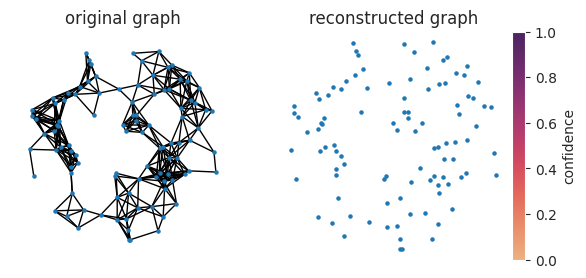

tensor([[0.5076, 0.4924],
        [0.5076, 0.4924],
        [0.5076, 0.4924],
        ...,
        [0.5076, 0.4924],
        [0.5076, 0.4924],
        [0.5076, 0.4924]], device='cuda:0')


In [19]:
# evaluate embedding
predictions, pred_labels, probabilities = evaluator.evaluate()
print(probabilities)

In [20]:
counts = [0, 0]
for _, (_, y) in enumerate(evaluator.train_dataloader):
    ones = y.cpu().sum()
    counts[0] += len(y) - ones
    counts[1] += ones
print(counts)
print(counts[0] + counts[1])
print(len(evaluator.train_dataset))

[tensor(1924), tensor(2037)]
tensor(3961)
3961
